In [1]:
import pandas as pd
import numpy as np
import datetime

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from scipy import optimize

In [3]:
data = pd.read_excel("UK_data.xlsx")

In [4]:
data = data[['Date of deaths', 'new', 'total','active cases']].copy()

In [5]:
data['numb'] = range(len(data)) 
data['numb'] = data['numb'] + 1
data= data.set_index('Date of deaths')

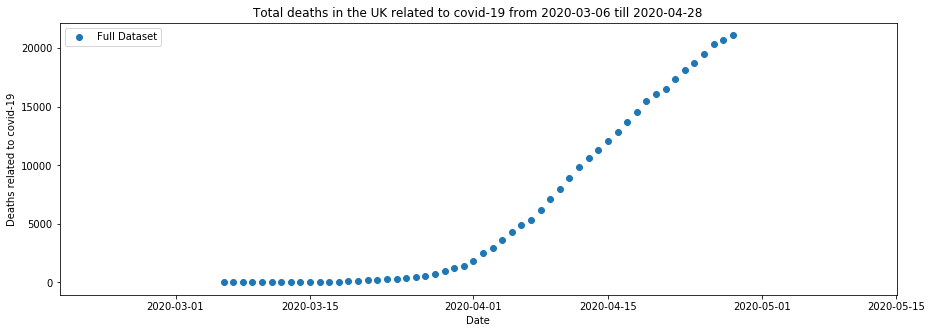

In [6]:
x = data.index
y = data["total"]
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x, y, label = 'Full Dataset')
ax.set_xlabel("Date")
ax.set_ylabel('Deaths related to covid-19')
ax.set_title('Total deaths in the UK related to covid-19 from 2020-03-06 till 2020-04-28')
plt.legend(loc='upper left')
plt.show()


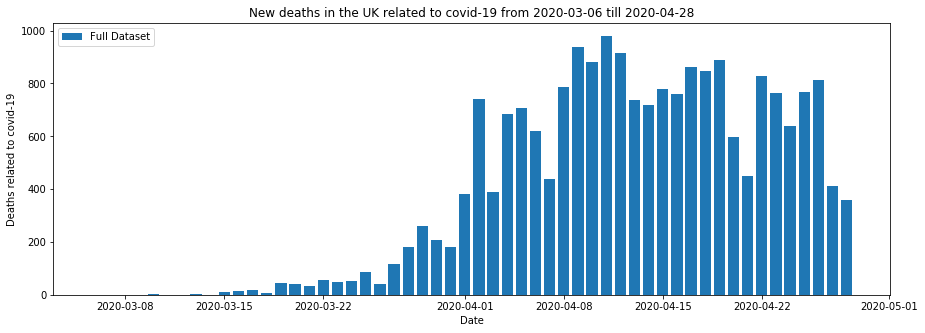

In [7]:
x = data.index
y = data["new"]
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x, y, label = 'Full Dataset')
ax.set_xlabel("Date")
ax.set_ylabel('Deaths related to covid-19')
ax.set_title('New deaths in the UK related to covid-19 from 2020-03-06 till 2020-04-28')
plt.legend(loc='upper left')
plt.show()

In [9]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 400*x

linear = f(x=data['numb'].values)

'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''

def f(x): 
    return 45000 / (1 + np.exp(-0.1*(x-50)))

logistic = f(x=np.arange(100))

'''
cubed function: f(x) = x*3
'''
def f(x):
    return 0.17*(x**3)

cubed = f(x=data['numb'].values)
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 4*(1.2**(x))

exponential = f(x=data['numb'].values)

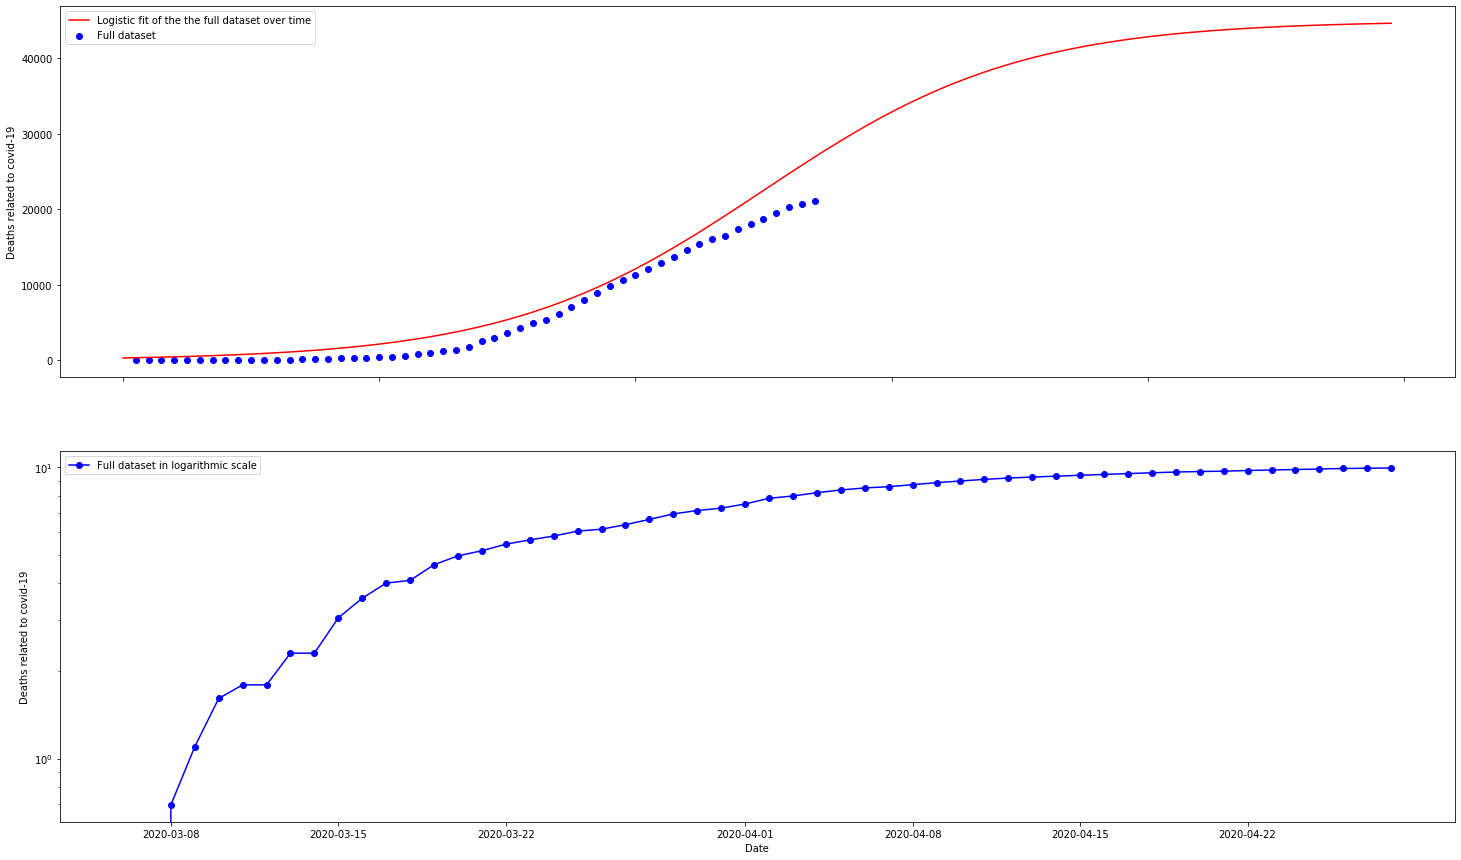

In [10]:
xs = data['numb']
xl = np.arange(100)
ys = data["total"].values
ylog = np.log(ys)
fig, (ax1,ax2) = plt.subplots(2, figsize=(25,15))
ax1.scatter(xs, data["total"].values, label = 'Full dataset', color="blue")
ax1.plot(logistic, label="Logistic fit of the the full dataset over time", color="red")
plt.plot(data.index, ylog,'bo-', label = 'Full dataset in logarithmic scale', color = 'blue')
ax2.set_yscale('log')
ax1.set_ylabel('Deaths related to covid-19'), ax2.set_ylabel('Deaths related to covid-19'), ax2.set_xlabel('Date')
ax1.legend(), ax2.legend()
ax1.set_xticklabels([])

plt.show()

In [11]:
data_1 = data[data.index <= '2020-03-25']

In [12]:
data_2 = data[data.index <= '2020-04-11']

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(15, 8))
ax1.scatter(data_1.index, data_1["total"], label = 'Data till 2020-03-25')
ax2.scatter(data_2.index, data_2["total"], label = 'Data till 2020-04-11')
ax1.set_yscale('log'), ax2.set_yscale('log')
ax1.legend(), ax2.legend()
ax2.set_yscale('log')
ax1.set_ylabel('Deaths related to covid-19 (log scale)'), ax2.set_ylabel('Deaths related to covid-19 (log scale)')
ax2.set_xlabel('Date'), ax1.set_xlabel('Date')

plt.show()


In [34]:
'''
Logistic function: f(x) = L / (1 + e^-k(*(x-m)))
L - maximum capacity
k - logistic growth rate
m = the x value of the sigmoid's midpoint
'''
def logistic_f(X, L, k, m):
    y = L / (1 + np.exp(-k*(X-m)))
    return y
'''
parameters of logictis function are optimized using Nonlinear least squares estimation
'''
def optimization_model(function, data):
    logistic_model, cov = optimize.curve_fit(function,
                                xdata=np.arange(len(data)), 
                                ydata=data.values, 
                                maxfev=20000
                                            )
    return(logistic_model)
def optimization_custom1(function, data):
    logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=np.arange(len(data)), 
                                ydata=data.values, 
                                maxfev=20000,
                                bounds = ([65000, 0.2,1],[100000,3.,10000]),
                                p0=[65000, 0.2, 1]
                                            )
    return(logistic_model)
def optimization_custom2(function, data):
    logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=np.arange(len(data)), 
                                ydata=data.values, 
                                maxfev=20000,
                                bounds = ([29100, 0.2,1],[100000,3.,100]),
                                p0=[29100, 0.2, 1])
    return(logistic_model)

In [35]:
entire_function = optimization_model(logistic_f, data["total"])

In [36]:
function_1 = optimization_custom1(logistic_f, data_1["total"])

In [37]:
function_2 = optimization_custom2(logistic_f, data_2["total"])

In [38]:
def graph_parts(data, function, date):
    xs = data['numb']
    ys = data["total"].values
    fig, ax = plt.subplots(figsize=(25,15))
    plt.plot(ys,'bo-', label = date)
    ax.plot(logistic_f(np.arange(len(data)), function[0],function[1],function[2]), color="red", label = 'Logistic fit of data over this period')
    ax.set_ylabel('Deaths related to covid-19'), ax.set_xlabel('Date')
    for x,y in zip(xl,ys):
        label = "{:}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    ax.legend()
    return(plt.show())

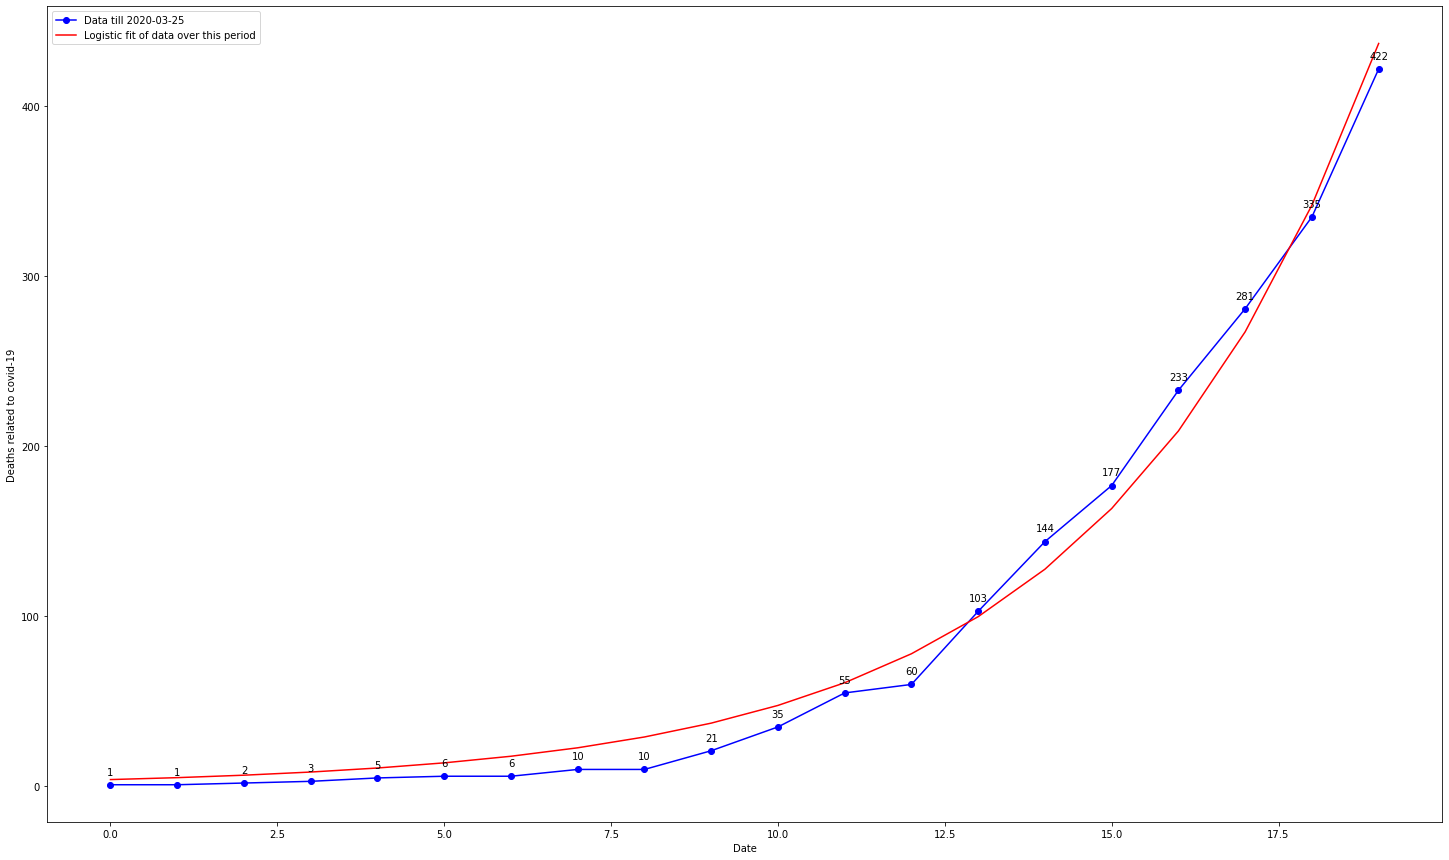

In [20]:
graph_parts(data_1, function_1, 'Data till 2020-03-25')

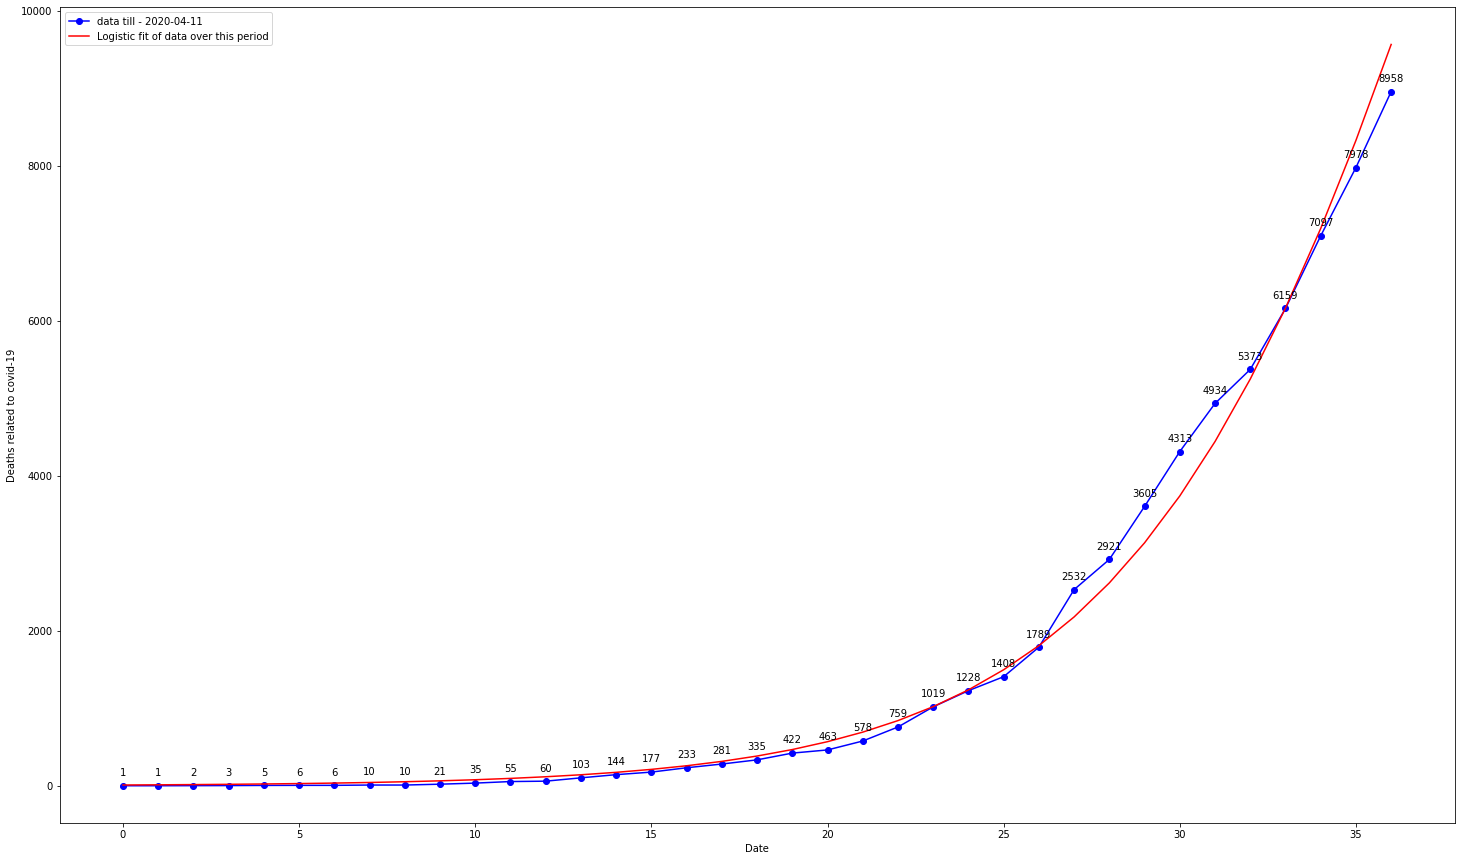

In [22]:
graph_parts(data_2, function_2, 'data till - 2020-04-11')

In [108]:
'''
Predict future values of data points.
pred_ahead: number of data points to predict
freq: 'D' daily
'''
def forecast_curve(data, function, model, start, pred_ahead=None, freq="D", figsize=(15,5)):
    timesteps = np.arange(len(data))
    fitted = function(timesteps, model[0], model[1], model[2])
    final = data.to_frame(name="data")
    final["model"] = fitted
    ## index
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    timestamps_new = np.arange(len(timesteps)+1, len(timesteps)+1+len(index))
    preds = function(timestamps_new, model[0], model[1], model[2])
    final = final.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    array = np.concatenate((fitted, preds), axis=0)

    return final, array

In [102]:
preds, values = forecast_curve(data["total"], logistic_f, entire_function, start = '2020-04-29',
                       pred_ahead=1, freq="D")
preds_2, values_2 = forecast_curve(data_2["total"], logistic_f, function_2, start = '2020-04-11',
                       pred_ahead=19, freq="D")
preds_1, values_1 = forecast_curve(data_1["total"], logistic_f, function_1, start = '2020-03-25',
                       pred_ahead=36, freq="D")

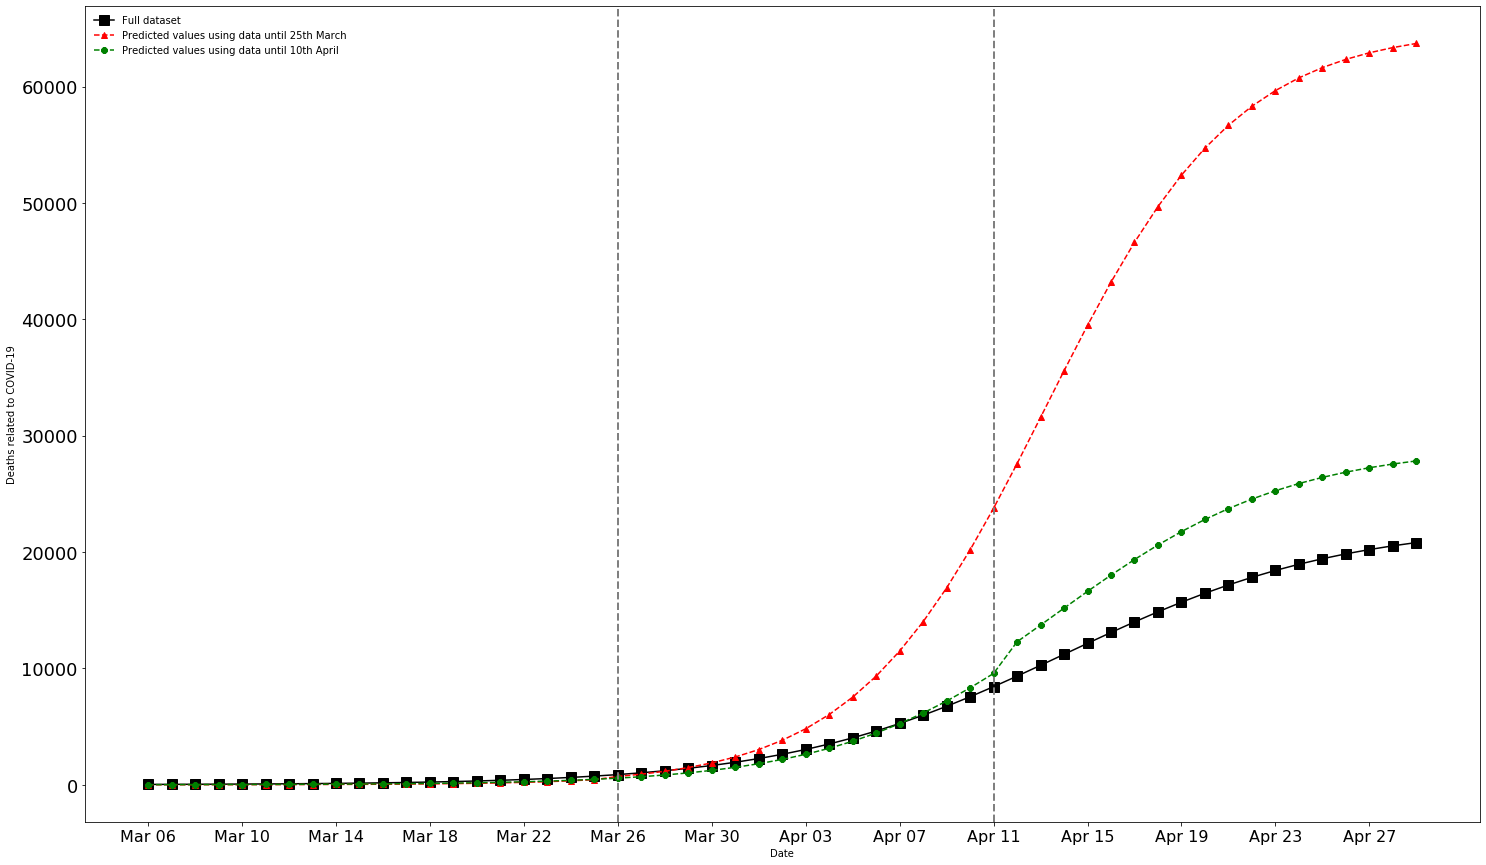

In [106]:
arr = preds_1.index
ar = np.arange(len(data['new'].values))
fig, ax = plt.subplots(figsize=(25,15))
ax.plot(arr, values, 'bo-', label="Full dataset", color="black", marker = 's', markersize=10)
ax.plot(arr, values_1, 'bo-', label="Predicted values using data until 25th March", color="red", marker = '^',linestyle = 'dashed')
ax.plot(arr, values_2, 'bo-', label="Predicted values using data until 10th April", color="green", marker = '8',linestyle = 'dashed')
ax.legend(frameon=False)
plt.axvline(datetime.datetime(2020, 4, 11),linewidth=2, color='grey',linestyle = 'dashed')
plt.axvline(datetime.datetime(2020, 3, 26),linewidth=2, color='grey',linestyle = 'dashed')
ax.set_ylabel('Deaths related to COVID-19'), ax.set_xlabel('Date')
plt.xticks(x[::4])
plt.rcParams.update({'font.size': 20})
ax.tick_params(axis="x", labelsize=16), ax.tick_params(axis="y", labelsize=18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.savefig('Fig.pdf')
plt.show()
